# Read in a dataset, resample the data and create a plot

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

For this we will be using the `starwinds_readplt` Python package which I developed. The package has to be installed from GitHub via the url https://github.com/svaberg/starwinds-readplt. If you have `git` installed this is as simple as typing
```bash
git clone git@github.com:svaberg/starwinds-readplt.git
cd starwinds-readplt
```
and following the instructions on the project's GitHub page.

In [4]:
from starwinds_readplt.dataset import Dataset
ds = Dataset.from_file("Data/3d__var_3_n00060000.plt")
print(ds)

Title:     'BATSRUS: 3D Data, 2000/01/30 00:00:00.000'
Zone:      '3D   N=0060000'
Variables: 24
Shape:     (4849664, 24)
Variables: ['X [R]', 'Y [R]', 'Z [R]', 'Rho [g/cm^3]', 'U_x [km/s]', 'U_y [km/s]', 'U_z [km/s]', 'ti [K]', 'te [K]', 'B_x [Gauss]', 'B_y [Gauss]', 'B_z [Gauss]', 'I01 [erg/cm^3]', 'I02 [erg/cm^3]', 'P [dyne/cm^2]', 'pe [dyne/cm^2]', 'E [erg/cm^3]', 'ehot [erg/cm^3]', 'qrad J/m^3/s', 'qheat J/m^3/s', 'refl 1/s', 'J_x [`mA/m^2]', 'J_y [`mA/m^2]', 'J_z [`mA/m^2]'].


Now we will use the `numpy` and `scipy` packages to re-sample the data onto a 2D plane. This is done in two steps. First, an 'interpolator' object is created. This masquerades as a function which one can query for the data values in any point.

In [5]:
from scipy.interpolate import NearestNDInterpolator  # This is fast and should be used for testing and development.
from scipy.interpolate import LinearNDInterpolator  # This is much slower but should be used for generating the final figures.

ds_points = np.stack([ds(name) for name in ds.variables[:3]], axis=-1)
ds_data = np.stack([ds(name) for name in ds.variables], axis=-1)
interpolator = NearestNDInterpolator(ds_points, ds_data)

## Create a 2D plane onto which to interpolate the 3D data we read in. 
Here we just use the stellar equatorial plane. The `interpolator` object is used to compute values at the exact points in the plane. The re-sampled density value is then plotted in log-scale.

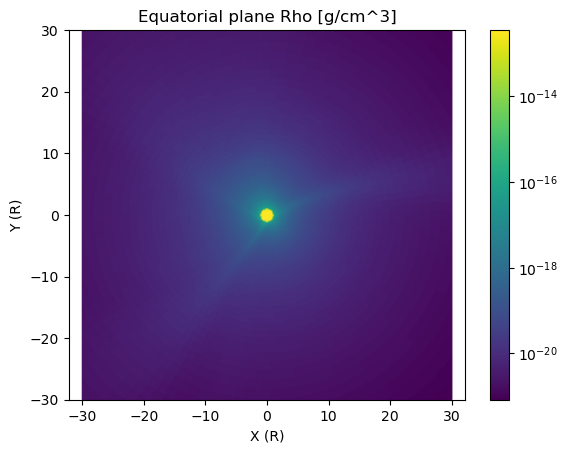

In [6]:
x = np.linspace(-30, 30, 301)  # Units are solar/stellar radii
y = np.linspace(-30, 30, 303)  # Use different number of elements in x and y direction to avoid confusing them later on.
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

interpolated_data = interpolator(X, Y, Z)

variable_name = 'Rho [g/cm^3]'
plt.pcolormesh(X, Y, interpolated_data[...,ds.variables.index(variable_name)], shading='gouraud', norm='log')
plt.colorbar()
plt.axis("equal")
plt.xlabel('X (R)')
plt.ylabel('Y (R)')
plt.title(f'Equatorial plane {variable_name}')
plt.show()

## Create a circular orbit and sample values along the orbit
The orbit is counterclockwise as seen from the positive $z$-axis and starts in the quadrant where $x$ and $y$ are both positive. The `interpolator` object is used to compute the values at the exact points of the orbit. We plot from 0 to 330 degrees to highlight the orientation of the rotation. The initial point of the orbit is shown in orange.

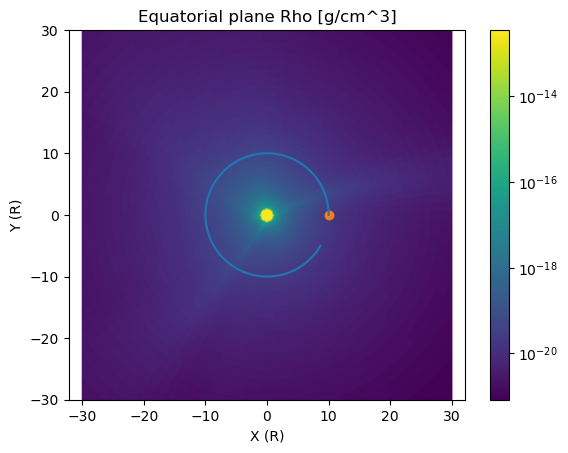

In [8]:
orbit_radius = 10  # Stellar radii
phase_angle = np.linspace(0, 330, 300)
orbit_x_pos = orbit_radius * np.cos(np.deg2rad(phase_angle))
orbit_y_pos = orbit_radius * np.sin(np.deg2rad(phase_angle))
orbit_z_pos = np.zeros_like(orbit_x_pos)

plt.pcolormesh(X, Y, interpolated_data[...,ds.variables.index(variable_name)], shading='gouraud', norm='log')
plt.plot(orbit_x_pos, orbit_y_pos, color='C0')
plt.plot(orbit_x_pos[0], orbit_y_pos[0], color='C1', marker='o', zorder=1)
plt.colorbar()
plt.axis("equal")
plt.xlabel('X (R)')
plt.ylabel('Y (R)')
plt.title(f'Equatorial plane {variable_name}')
plt.show()

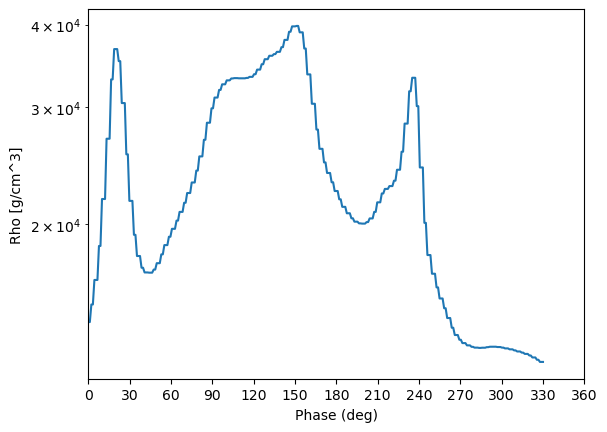

14248.208530505282
243262.2


In [13]:
plt.semilogy(phase_angle, interpolator(orbit_x_pos, orbit_y_pos, orbit_z_pos)[...,ds.variables.index('Rho [g/cm^3]')] * 6.02e23)
# plt.semilogy(phase_angle[0], interpolator(orbit_x_pos[0], orbit_y_pos[0], orbit_z_pos[0])[...,ds.variables.index('Rho [g/cm^3]')], 'o')
plt.xlabel('Phase (deg)')
plt.ylabel(variable_name)
plt.xlim(0, 360)
plt.xticks(30 * np.arange(13))
plt.show()
print(interpolator(orbit_x_pos, orbit_y_pos, orbit_z_pos)[...,ds.variables.index('Rho [g/cm^3]')][0] * 6.02e23)
print(interpolator(orbit_x_pos, orbit_y_pos, orbit_z_pos)[...,ds.variables.index('ti [K]')][0])